# A/B Testing on Audacity portal

A/B tests are used to test changes on a web page by running an experiment where a control group sees the old version, while the experiment group sees the new version. A metric is then chosen to measure the level of engagement from users in each group. These results are then used to judge whether one version is more effective than the other. A/B testing is very much like hypothesis testing with the following hypotheses:

- Null Hypothesis: The new version is no better, or even worse, than the old version
- Alternative Hypothesis: The new version is better than the old version

If we fail to reject the null hypothesis, the results would suggest keeping the old version. If we reject the null hypothesis, the results would suggest launching the change. These tests can be used for a wide variety of changes, from large feature additions to small adjustments in color, to see what change maximizes your metric the most.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
np.random.seed(42)

df = pd.read_csv('datasets/homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


## Testing on Home page 

### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [2]:
# total number of actions
df.shape

(8188, 4)

In [3]:
# number of unique users
df.nunique()

timestamp    8188
id           6328
group           2
action          2
dtype: int64

In [4]:
# size of control group and experiment group
group = df.groupby('group')['id'].nunique()
control_size = group[0]
experiment_size = group[1]
control_size , experiment_size

(3332, 2996)

### 2. How long was the experiment run for? 
Hint: the records in this dataset are ordered by timestamp in increasing order

In [5]:
# duration of this experiment
df.timestamp.max(),df.timestamp.min()

('2017-01-18 10:24:08.629327', '2016-09-24 17:42:27.839496')

### 3. What action types are recorded in this dataset?
(i.e., What are the unique values in the action column?)

In [6]:
# action types in this experiment
df.action.unique()

array(['view', 'click'], dtype=object)

In [7]:
df.action.value_counts()

view     6328
click    1860
Name: action, dtype: int64

### 4. Why would we use click through rate instead of number of clicks to compare the performances of control and experiment pages?

> The control and experiment pages could have different number of total visitors.

> More total clicks could occur in one version, even if the percentage of total clicks is greater in other version. 

> Hence comparing the proprotion of clicks is more effective when compared to counting the number of clicks when the total users are different for both groups

### 5. Define the click through rate (CTR) for this experiment.

>Number of unique visitors who click atleast once divided by the number of unique visitors who view the page

In [9]:
ctr = df.query('action == "click"').id.nunique() / df.query('action == "view"').id.nunique()
ctr

0.2939317319848293

### 6. What are the null and alternative hypotheses?
Use $CTR_{old}$ and $CTR_{new}$ in your hypotheses.

$$H_0: $$ $CTR_{new}$ - $CTR_{old}$ <= 0  
$$H_1: $$ $CTR_{new}$ - $CTR_{old}$ > 0

#### lets find the click through rate for control group ie $CTR_{old}$

In [10]:
control_df = df.query("group == 'control'")
ctr_control = control_df.query('action == "click"').id.nunique() / control_df.query('action == "view"').id.nunique()
ctr_control

0.2797118847539016

In [11]:
experiment_df = df.query("group == 'experiment'")
ctr_experiment = experiment_df.query('action == "click"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
ctr_experiment

0.3097463284379172

In [12]:
obs_diff = ctr_experiment - ctr_control
obs_diff

0.030034443684015644

Now that we know the observed difference in the sample, we have to see if this difference is significant and just not due to chance. Lets bootstrap the sample to simulate the sampling distribution for difference in proportions.

In [13]:
diffs=[]
for i in range(10000):
    samp = df.sample(df.shape[0],replace=True)
    control_df = samp.query("group == 'control'")
    experiment_df = samp.query("group == 'experiment'")
    ctr_control = control_df.query('action == "click"').id.nunique() / control_df.query('action == "view"').id.nunique()
    ctr_experiment = experiment_df.query('action == "click"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
    diffs.append(ctr_experiment - ctr_control)


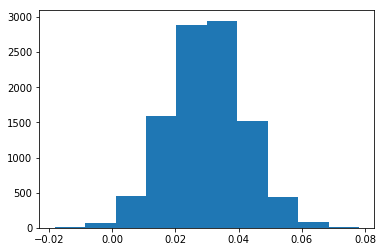

In [14]:
plt.hist(diffs);

In [15]:
diffs = np.array(diffs)
null_vals = np.random.normal(0,diffs.std(),diffs.size)

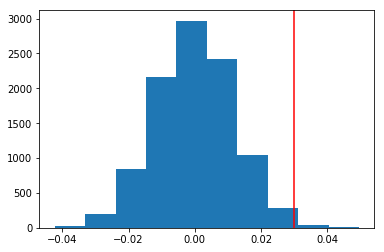

In [17]:
plt.hist(null_vals);
plt.axvline(x=obs_diff , color='r');

In [18]:
p_value = (null_vals>obs_diff).mean()
p_value

0.0061

With a p-value of almost half a percent, the difference in click through rates for control and experiment does appear to be significant. with a p value of less than 0.01, it seems unlikely that our statistic is from null hypothesis. **`Hence we can reject the null hypothesis.`** and based on these results it looks like audacity should launch the new version of home page.

## Testing on course overview page

 The second change Audacity is A/B testing is a more career focused description on a course overview page. They hope that this change may encourage more users to enroll and complete this course. In this experiment, we’re going to analyze the following metrics:

   **`Enrollment Rate`**: Click through rate for the Enroll button the course overview page
   
   **`Average Reading Duration`**: Average number of seconds spent on the course overview page
   
   **`Average Classroom Time`**: Average number of days spent in the classroom for students enrolled in the course
   
   **`Completion Rate`**: Course completion rate for students enrolled in the course

First, let's determine if the difference observed for each metric is statistically significant individually.


## Metric - Enrollment Rate

In [20]:
df = pd.read_csv('datasets/course_page_actions.csv')
df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


In [22]:
df.action.unique()

array(['view', 'enroll'], dtype=object)

In [21]:
# Get dataframe with all records from control group
control_df = df.query('group == "control"')

# Compute click through rate for control group
control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()

# Display click through rate
control_ctr

0.2364438839848676

In [23]:
# Get dataframe with all records from experiment group
experiment_df = df.query('group == "experiment"')

# Compute click through rate for experiment group
experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()

# Display click through rate
experiment_ctr

0.2668693009118541

In [24]:
# Compute the observed difference in click through rates
obs_diff = experiment_ctr - control_ctr

# Display observed difference
obs_diff

0.030425416926986526

In [25]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
    diffs.append(experiment_ctr - control_ctr)


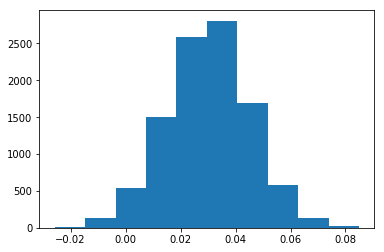

In [26]:
# Convert to numpy array
diffs = np.array(diffs)

# Plot sampling distribution
plt.hist(diffs);

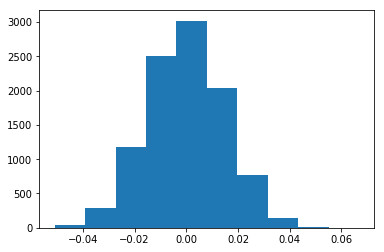

In [27]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0,diffs.std(),diffs.size)

# Plot the null distribution
plt.hist(null_vals);

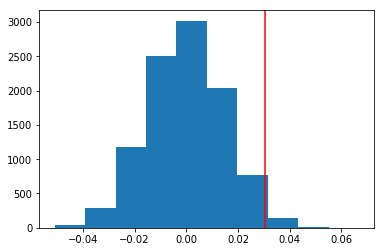

In [28]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(x=obs_diff,color='r');


In [30]:
# Compute p-value
p_value = (null_vals>obs_diff).mean()
p_value

0.0188

with a type I error rate of 0.05, and p value of 0.019 it is evident that p_value < type1 error rate, Hence **`Null hypothesis can be rejected.`**

## Metric - Average Reading Duration

In [31]:
# filter by view action
views = df.query("action == 'view'")

Lets only count each unique user once by finding their average reading duration if they visited the site more than once.

In [32]:
reading = views.groupby(['id','group'])['duration'].mean()
reading = reading.reset_index()

In [33]:
reading.head()

,id,group,duration
0,183260,control,107.331484
1,183615,experiment,24.627594
2,184277,experiment,193.212489
3,184360,experiment,226.586283
4,184589,experiment,12.052097


In [37]:
# average redaing durations for each group
control_mean = reading.query("group == 'control'")['duration'].mean()
experiment_mean = reading.query("group == 'experiment'")['duration'].mean()
control_mean , experiment_mean

(115.38637100678449, 131.32084104717944)

In [38]:
obs_diff = experiment_mean - control_mean
obs_diff

15.934470040394956

In [39]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
size = reading.shape[0]
for _ in range(10000):
    b_samp = reading.sample(size, replace=True)
    control_mean = b_samp.query('group == "control"')['duration'].mean()
    experiment_mean = b_samp.query('group == "experiment"')['duration'].mean()
    diffs.append(experiment_mean - control_mean)
    

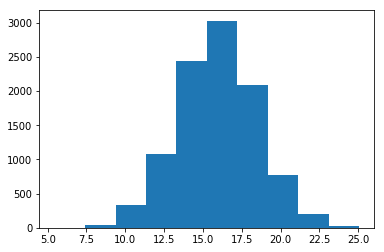

In [40]:
diffs = np.array(diffs)
plt.hist(diffs);

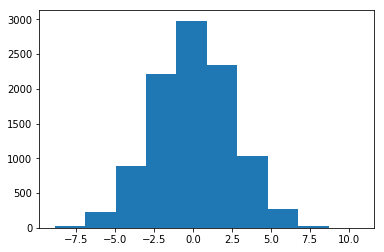

In [41]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0,diffs.std(),diffs.size)

# Plot the null distribution
plt.hist(null_vals);

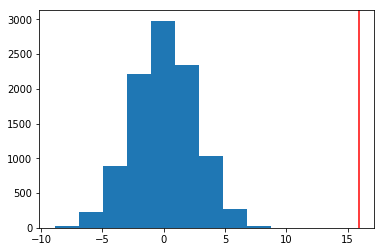

In [42]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(x=obs_diff,color='r');

It is significant from the distribution it self that, **`Null Hypothesis can be rejected.`**

## Metric - Average Classroom Time

In [44]:
df = pd.read_csv('datasets/classroom_actions.csv')
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [45]:
# The total_days represents the total amount of time
# each student has spent in classroom.
# get the average classroom time for control group
control_mean = df.query("group == 'control'")['total_days'].mean()

# get the average classroom time for experiment group
experiment_mean = df.query("group == 'experiment'")['total_days'].mean()

# display average classroom time for each group
control_mean, experiment_mean

(73.36899038461539, 74.6715935334873)

In [46]:
# compute observed difference in classroom time
obs_diff = experiment_mean - control_mean

# display observed difference
obs_diff

1.3026031488719099

In [47]:
# create sampling distribution of difference in average classroom times
# with boostrapping
diffs = []
for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace=True)
    control_mean = b_samp.query('group == "control"')['total_days'].mean()
    experiment_mean = b_samp.query('group == "experiment"')['total_days'].mean()
    diffs.append(experiment_mean - control_mean)



In [48]:
# convert to numpy array
diffs = np.array(diffs)


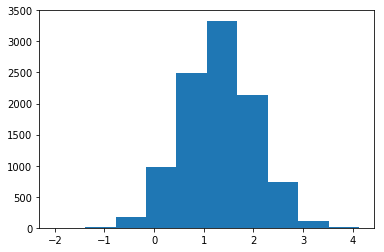

In [49]:
# plot sampling distribution
plt.hist(diffs);

In [58]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0,diffs.std(),diffs.size)

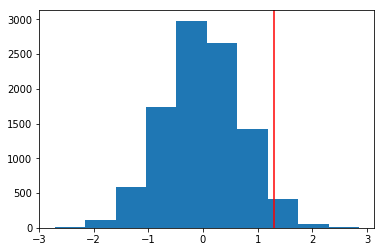

In [59]:
# plot null distribution
plt.hist(null_vals);
plt.axvline(x=obs_diff,color='r');
# plot line for observed statistic


In [60]:
# compute p value
p_value = (null_vals>obs_diff).mean()
p_value

0.0339

with a type I error rate of 0.05, and p value of 0.03 it is evident that p_value < type1 error rate, Hence **`Null hypothesis can be rejected.`**

## Metric - Completion Rate

In [61]:
# Create dataframe with all control records
control_df = df.query('group == "control"')

# Compute completion rate
control_ctr = control_df['completed'].mean()

# Display control complete rate
control_ctr

0.3719951923076923

In [62]:
# Create dataframe with all experiment records
experiment_df = df.query('group == "experiment"')

# Compute completion rate
experiment_ctr = experiment_df['completed'].mean()

# Display experiment complete rate
experiment_ctr

0.3935334872979215

In [63]:
# Compute observed difference in completion rates
obs_diff = experiment_ctr - control_ctr

# Display observed difference in completion rates
obs_diff

0.02153829499022919

In [64]:
# Create sampling distribution for difference in completion rates
# with boostrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df['completed'].mean()
    experiment_ctr = experiment_df['completed'].mean()
    diffs.append(experiment_ctr - control_ctr)

In [65]:
# convert to numpy array
diffs = np.array(diffs)

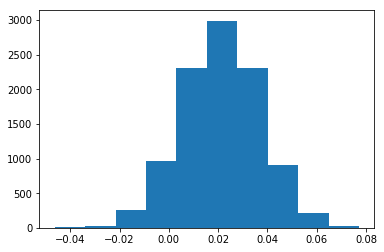

In [66]:
# plot distribution
plt.hist(diffs);

In [70]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

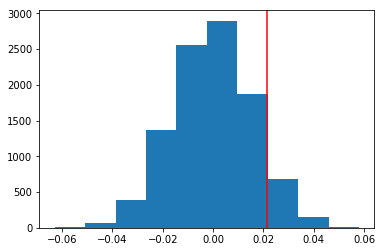

In [71]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff, c='red');

In [72]:
# compute p value
(null_vals > obs_diff).mean()

0.0861

with a type I error rate of 0.05, and p value of 0.08 it is evident that p_value > type1 error rate, Hence **`Null hypothesis fails to be rejected.`**

## Drawing Conclusions

Let's see which of our metrics produced statistically significant differences based on this new Bonferroni corrected alpha value. Here are the p-values computed for the four metrics in this experiment. (These are the values you should've gotten with a random seed of 42.)

    Enrollment Rate: 0.0188
    Average Reading Duration: 0
    Average Classroom Time: 0.0384
    Completion Rate: 0.0846


bonferoni corrected alpha value is 0.05 / 10000 = 0.000005

> **hence after bonferoni correction only average reading duration is statistically significant**

Since the Bonferroni method is too conservative when we expect correlation among metrics, we can better approach this problem with more sophisticated methods, such as the closed testing procedure, Boole-Bonferroni bound, and the Holm-Bonferroni method. These are less conservative and take this correlation into account.

If you do choose to use a less conservative method, just make sure the assumptions of that method are truly met in your situation, and that you're not just trying to cheat on a p-value. Choosing a poorly suited test just to get significant results will only lead to misguided decisions that harm your company's performance in the long run.


# Difficulties in A/B Testing

As you saw in the scenarios above, there are many factors to consider when designing an A/B test and drawing conclusions based on its results. To conclude, here are some common ones to consider.

- Novelty effect and change aversion when existing users first experience a change
- Sufficient traffic and conversions to have significant and repeatable results
- Best metric choice for making the ultimate decision (eg. measuring revenue vs. clicks)
- Long enough run time for the experiment to account for changes in behavior based on time of day/week or seasonal events.
- Practical significance of a conversion rate (the cost of launching a new feature vs. the gain from the increase in conversion)
- Consistency among test subjects in the control and experiment group (imbalance in the population represented in each group can lead to situations like Simpson's Paradox)
